In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("whitegrid")

In [ ]:
import os
from urllib.request import urlopen
import ssl, certifi
import pandas as pd

# Ensure ../data exists (run this from src/)
os.makedirs("../data", exist_ok=True)

# Reusable SSL context (same as your olympics example)
ctx = ssl.create_default_context(cafile=certifi.where())

urls = {
    "unvotes":    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/unvotes.csv",
    "roll_calls": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/roll_calls.csv",
    "issues":     "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/issues.csv",
}

for name, url in urls.items():
    with urlopen(url, context=ctx) as f:
        df = pd.read_csv(f)
    out_path = f"../data/{name}.csv"
    df.to_csv(out_path, index=False)
    print(f"✅ Saved to {out_path}")

In [3]:
unvotes    = pd.read_csv('../data/unvotes.csv')
roll_calls = pd.read_csv('../data/roll_calls.csv')
issues = pd.read_csv('../data/issues.csv')

## unvotes

In [ ]:
unvotes.head()

In [ ]:
unvotes.info()

In [ ]:
unvotes[unvotes["country_code"].isna()]

In [ ]:
unvotes[(unvotes["country"] == "Yemen Arab Republic") & (unvotes["country_code"].notna())]

In [ ]:
unvotes[(unvotes["country"] == "Namibia") & (unvotes["country_code"].notna())]

Lets drop `country_code` and just use `country`

## roll_calls

In [ ]:
roll_calls.head()

In [ ]:
roll_calls.info

In [ ]:
roll_calls["short"].unique()

In [ ]:
roll_calls["unres"].unique()

In [ ]:
roll_calls["importantvote"].count()

## issues

In [ ]:
issues.head()

In [ ]:
issues.info()

In [ ]:
issues["short_name"].unique()

In [ ]:
issues["issue"].unique()

In [ ]:
issues[issues["issue"] == "Palestinian conflict"]

Lets drop `short_name` because `issue` gives the same information, and a better description

## Huh

In [ ]:
any(unvotes.duplicated()) or any(roll_calls.duplicated()) or any(issues.duplicated())

## OK

In [4]:
unvotes = unvotes.drop("country_code", axis=1)
roll_calls = roll_calls[["rcid", "session", "importantvote", "date"]]
issues = issues.drop("short_name", axis=1)

In [5]:
roll_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6202 entries, 0 to 6201
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rcid           6202 non-null   int64  
 1   session        6202 non-null   int64  
 2   importantvote  5598 non-null   float64
 3   date           6202 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 193.9+ KB


In [6]:
roll_calls.dropna(inplace=True)

In [7]:
roll_calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5598 entries, 0 to 6111
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rcid           5598 non-null   int64  
 1   session        5598 non-null   int64  
 2   importantvote  5598 non-null   float64
 3   date           5598 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 218.7+ KB


In [8]:
roll_calls["date"] = pd.to_datetime(roll_calls["date"]).dt.year

mapping = {
    "yes": 1,
    "abstain": 0,
    "no": -1
}
unvotes["vote"] = unvotes["vote"].map(mapping)

In [9]:
df = roll_calls.merge(unvotes, on="rcid").merge(issues, on="rcid").reset_index(drop=True)

In [10]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783214 entries, 0 to 783213
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rcid           783214 non-null  int64  
 1   session        783214 non-null  int64  
 2   importantvote  783214 non-null  float64
 3   date           783214 non-null  int32  
 4   country        783214 non-null  object 
 5   vote           783214 non-null  int64  
 6   issue          783214 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 38.8+ MB


(783214, 7)

In [11]:
df['vote'].describe()

count    783214.00000
mean          0.74417
std           0.56340
min          -1.00000
25%           1.00000
50%           1.00000
75%           1.00000
max           1.00000
Name: vote, dtype: float64

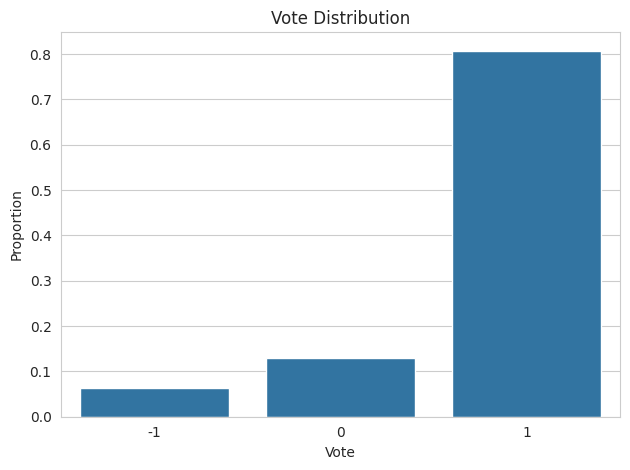

In [12]:
sns.countplot(data=df, x='vote', stat='proportion')
plt.title('Vote Distribution')
plt.ylabel('Proportion')
plt.xlabel('Vote')
plt.tight_layout()

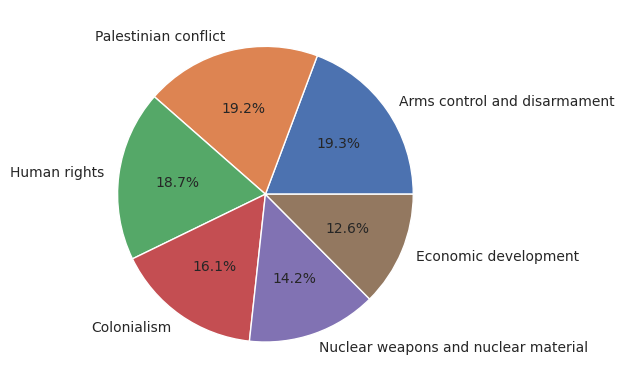

In [13]:
pi = df['issue'].value_counts()
plt.pie(pi, labels=pi.index, autopct='%1.1f%%', colors=sns.color_palette('deep'))
plt.show()

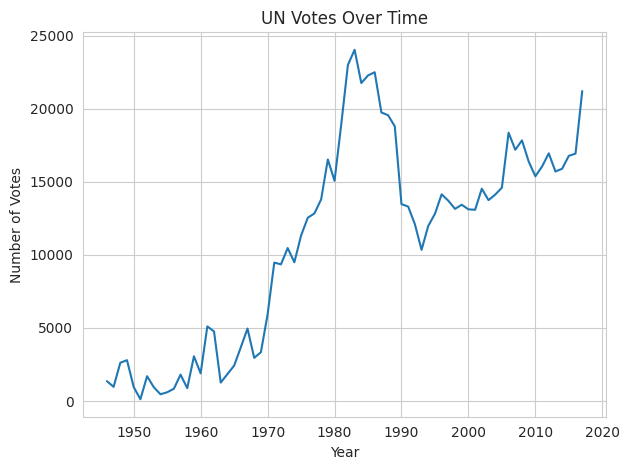

In [14]:
sns.lineplot(data=df, x='date', y='vote', estimator="count", errorbar=None)
plt.title("UN Votes Over Time")
plt.ylabel("Number of Votes")
plt.xlabel("Year")
plt.tight_layout()

In [15]:
df2 = df.groupby(['date', 'issue']).size().reset_index(name='counts')
df2['pct'] = df2.groupby('date')['counts'].transform(lambda x: x / x.sum())
df2.head()

,date,issue,counts,pct
0,1946,Colonialism,764,0.562178
1,1946,Economic development,493,0.362767
2,1946,Human rights,102,0.075055
3,1947,Colonialism,495,0.510836
4,1947,Economic development,107,0.110423


In [16]:
p = df2.pivot(index='date', columns='issue', values='pct')
p.head()

issue,Arms control and disarmament,Colonialism,Economic development,Human rights,Nuclear weapons and nuclear material,Palestinian conflict
date,,,,,,
1946,NaN,0.562178,0.362767,0.075055,NaN,NaN
1947,NaN,0.510836,0.110423,NaN,NaN,0.378741
1948,0.177235,0.244079,0.161192,0.127578,0.058060,0.231856
1949,0.076951,0.304223,0.150322,0.114531,0.060845,0.293128
1950,0.057471,0.701149,0.062696,0.119122,NaN,0.059561


<Axes: xlabel='date'>

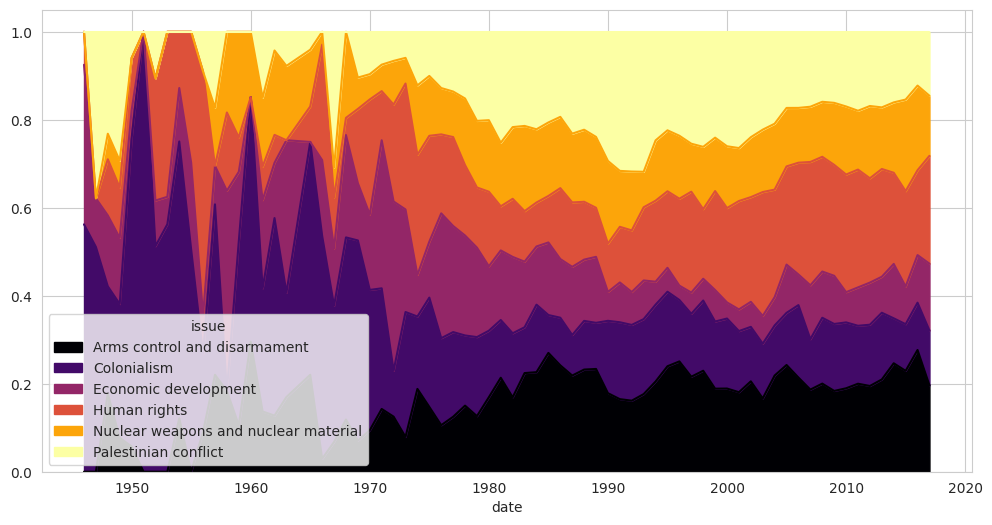

In [17]:
p.plot.area(figsize=(12, 6), colormap='inferno')